##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Code taken from: https://www.tensorflow.org/tutorials/generative/pix2pix

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2hed, hed2rgb
from skimage import img_as_float


## Load the dataset



In [ ]:
PATH = "/content/drive/MyDrive/hed_scans/fold12"
PATH_test = "/content/drive/MyDrive/fold3"
# OUPATH = "/content/drive/MyDrive/hed_scans/training"

Each original image is of size `256 x 512` containing two `256 x 256` images:

In [ ]:
sample_image = tf.io.read_file(str(PATH + '/136.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


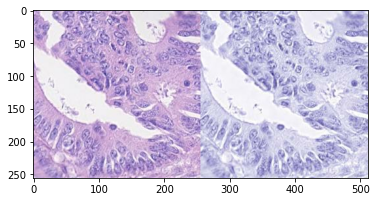

In [ ]:
plt.figure()
plt.imshow(sample_image)

You need to separate h&e images from the h ones of which will be of size `256 x 256`.


In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256


def resize(inimg, tgimg, height, width):
    inimg = tf.image.resize(inimg, [height, width])
    tgimg = tf.image.resize(tgimg, [height, width])

def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  #  input image is h only channel, real image should be ed

  return input_image, real_image

Plot a sample of the input  and real  images:

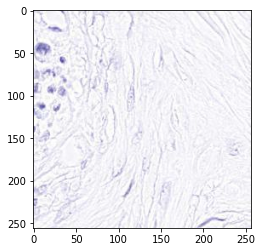

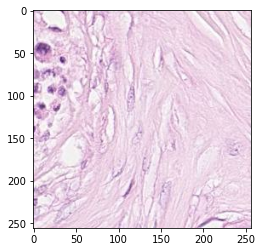

In [ ]:
inp, re = load(str(PATH +  '/137.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [ ]:
# The training set contains 3373 images
BUFFER_SIZE = 3373
# The batch size of 16 produced best results for the U-Net our pix2pix experiment
BATCH_SIZE = 16
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Build an input pipeline with `tf.data`

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(PATH + '/*.jpg'))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH_test + '/*.jpg'), shuffle=False)
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH_test + '/*.jpg'),shuffle=False)
  
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the generator


Define the downsampler (encoder):

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Define the generator with the downsampler and the upsampler:

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()


### Define the generator loss



In [ ]:
LAMBDA = 110

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Build the discriminator


Define the discriminator:

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()

### Define the discriminator loss


In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the optimizers and a checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images



Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [ ]:
def generate_images(model, test_input, tar, ):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

   for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

## Training



In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Training loop:

Time taken for 1000 steps: 93.08 sec



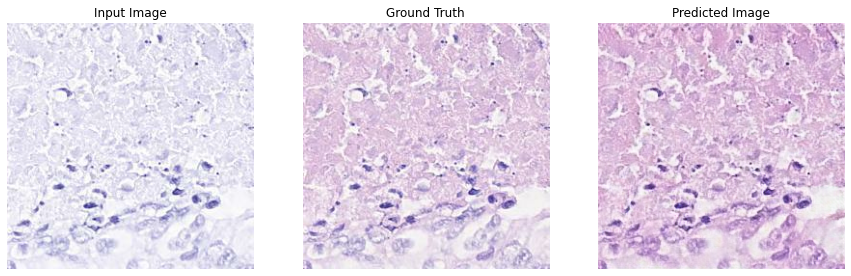

Step: 79k
....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=80000)

## Restore the latest checkpoint 

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Test the network


In [ ]:
def generate_images_test(model, test_input, tar):
  prediction = model(test_input, training=False)
  # plt.figure(figsize=(10, 10))

  display_list = [test_input[0], tar[0], prediction[0]]
  # display_list = display_list*0.5+0.5
  img = (tar[0]*0.5+0.5)*255
  img = np.array(img, dtype=np.uint8)
  img = Image.fromarray(img)

  im = (prediction[0]*0.5+0.5)*255
  im = np.array(im, dtype=np.uint8)
  im = Image.fromarray(im)

  h,e = get_ssim(display_list[1]*0.5+0.5, display_list[2]*0.5+0.5)
  return img, im, h, e


In [ ]:
fake = '/content/drive/MyDrive/fake/'

In [ ]:
for i in range(1608):
  test_dataset = tf.data.Dataset.list_files(str('/content/drive/MyDrive/fold3' + str(i) +'.jpg'), shuffle = False)
  test_dataset = test_dataset.map(load_image_test)
  test_dataset = test_dataset.batch(BATCH_SIZE)
  for inp,tar in test_dataset:
     _, fimg,h,e = generate_images_test(generator,inp,tar)
     fimg.save(fake +  str(i) + ".jpg", "JPEG")

Calculate SSIM on the test images


In [ ]:
def get_ssim(targ, pred):
  tar_hed = rgb2hed(targ)
  pred_hed = rgb2hed(pred)

  nullt = np.zeros_like(tar_hed[:,:,0])
  nullp = np.zeros_like(pred_hed[:,:,0])

  tar_h = hed2rgb(np.stack((tar_hed[:,:,0], nullt, nullt), axis=-1))
  tar_e = hed2rgb(np.stack((nullt, tar_hed[:,:,1], nullt), axis=-1))
 
  pred_h = hed2rgb(np.stack((pred_hed[:,:,0], nullp, nullp), axis=-1))
  pred_e = hed2rgb(np.stack((nullp, pred_hed[:,:,1], nullp), axis=-1))

  ssim_h = ssim(tar_h, pred_h, data_range=pred_h.max() - pred_h.min(),channel_axis=2)
  ssim_e = ssim(tar_e, pred_e, data_range=pred_e.max() - pred_e.min(),channel_axis=2)

  return ssim_h, ssim_e

  


In [ ]:
h_ssim = []
e_ssim = []
for inp, tar in test_dataset.take(1608):
  _,_, ssimh, ssime = generate_images_test(generator, inp, tar)
  h_ssim.append(ssimh)
  e_ssim.append(ssime)
  

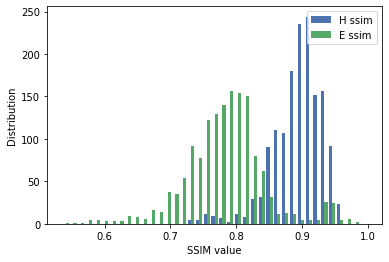

In [ ]:
plt.style.use('seaborn-deep')

lowerb = min(e_ssim)
bins = np.linspace(lowerb, 1, 40)


plt.hist([h_ssim, e_ssim], bins, label=['H ssim', 'E ssim'])
plt.legend(loc='upper right')
plt.xlabel("SSIM value")
plt.ylabel("Distribution")
plt.show()

In [ ]:
hssim = np.array(h_ssim)
essim = np.array(e_ssim)

goodh = 0
goode = 0

mean_h = np.mean(hssim)
var_h = np.var(hssim)
std_h = np.std(hssim)
max_h = max(h_ssim)
min_h = min(h_ssim)

mean_e = np.mean(essim)
var_e = np.var(essim)
std_e = np.std(essim)
max_e = max(e_ssim)
min_e = min(e_ssim)

for i in range(len(h_ssim)):
  if h_ssim[i]>=0.9:
    goodh+=1
  if e_ssim[i]>=0.8:
    goode+=1


print('Good H: ' + str(goodh) + ' and good E: ' + str(goode) )
print('H stain: The mean is ' + str(mean_h) + ', the variance is ' + str(var_h) + ' and the stadard deviations is: ' + str(std_h) + '.\nHighest value of ssim is ' + str(max_h) + ', while the lowest value is ' + str(min_h))
print('E stain: The mean is ' + str(mean_e) + ', the variance is ' + str(var_e) + ' and the stadard deviations is: ' + str(std_e) + '.\nHighest value of ssim is ' + str(max_e) + ', while the lowest value is ' + str(min_e))

Good H: 807 and good E: 590
H stain: The mean is 0.8944306085992435, the variance is 0.0013881811635456129 and the stadard deviations is: 0.037258303283236247.
Highest value of ssim is 0.958753314849973, while the lowest value is 0.7220489863707164
E stain: The mean is 0.7825754173277487, the variance is 0.003768890616149303 and the stadard deviations is: 0.061391291044815985.
Highest value of ssim is 0.98347088742901, while the lowest value is 0.5385655577590832
